# gplearn Survival

This notebook explores how to implement proportional hazards models with symbolic regression (with `gplearn`). This is a pre-requisite to doing it with SHAREs. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2

## 0. Test Data

We load the example Rossi dataset from `lifelines`, on which Cox PH achieves C-index of ~0.64.

In [2]:
from survshares.datasets import Rossi, Metabric, GBSG2
from sksurv.util import Surv

# Test dataset - Cox achieves C-index of 0.6403292470997135
dataset = Rossi()

# Test dataset - Cox achieves C-index of 0.6391503770136181
# dataset = Metabric()

# Test dataset - Cox achieves C-index of 0.5437638695233794
# dataset = GBSG2()

X, T, E = dataset.load(normalise=True)
X_train, X_test, T_train, T_test, E_train, E_test = dataset.split(random_state=42)
feature_names = dataset.features

## 1. Baseline Model - Cox PH

We fit a standard Cox PH as the model to beat. 

In [3]:
from lifelines import CoxPHFitter
from sksurv.util import Surv
from sksurv.metrics import integrated_brier_score

X_df = pd.DataFrame(X, columns=feature_names).assign(time=T, event=E)
cph = CoxPHFitter()
cph.fit(X_df, duration_col="time", event_col="event")
cph.print_summary()

# Double check the concordance
from lifelines.utils import concordance_index

c_index = concordance_index(T, -cph.predict_partial_hazard(X), E)
y, t = Surv.from_arrays(E, T), np.unique(T).astype(float)[1:-1]
ibs = integrated_brier_score(y, y, cph.predict_survival_function(X, times=t).T, t)
print(f"C-index: {c_index}")
print(f"IBS: {ibs}")    

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.75
         time fit was run = 2025-05-26 10:34:17 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
fin       -0.38      0.68      0.19           -0.75           -0.00                0.47                1.00
age       -0.35      0.70      0.13           -0.61           -0.09                0.54                0.92
race       0.31      1.37      0.31           -0.29            0.92                0.75                2.50
wexp      -0.15      0.86      0.21           -0.57            0.27                0.57                1.30
mar       -0.43      0.65      0.38           -1.18            0.31                0.31                1.37
paro      -0.08      0.92      0.20           -0.47            0.30                0.63                1.35
prio       0.26      1.30      0.08            0.10            0.43                1.11                1.53

           cmp to     z      p  -log2(p)
covariate                               
fin          0.00 -1.98   0.05      4.40
age          0.00 -2.61   0.01      6.79
race         0.00  1.02   0.31      1.70
wexp         0.00 -0.71   0.48      1.06
mar          0.00 -1.14   0.26      1.97
paro         0.00 -0.43   0.66      0.59
prio         0.00  3.19 <0.005      9.48
---
Concordance = 0.64
Partial AIC = 1331.50
log-likelihood ratio test = 33.27 on 7 df
-log2(p) of ll-ratio test = 15.37

C-index: 0.6403292470997135
IBS: 0.09467578840277147


## 2. Fitness Metrics
There are 3 options: 
 - The concordance (c-index) 
 - The DeepSurv/CoxTime ranking loss
 - The Cox partial likelihood (very similar)

DeepSurv/CoxTime also includes a shrink penalty in its loss to penalise the neural networks $g(t|x)$ from having values too far from 0. 

`gplearn` fitness functions normally depend only on `y_true` and `y_pred`, but we also require the event/censoring indicator. We pass the indicator as the `sample_weight` as a workaround to avoid modifying `gplearn` yet. 

In [4]:
# C-index
from lifelines.utils import concordance_index
from gplearn_clean.gplearn.fitness import make_fitness
from sklearn.metrics import make_scorer
import warnings

def metric_c_index(y_true, y_pred, sample_weight):
    """
    Protected concordance score metric for gplearn. Greater is better.
    """
    # y_true is the event time, y_pred is the predicted risk
    # sample_weight is the event indicator
    with warnings.catch_warnings():
        warnings.filterwarnings("error", category=RuntimeWarning)
        try:
            return concordance_index(y_true, np.exp(y_pred), sample_weight)
        except ZeroDivisionError:  # In case of no unambigous pairs
            return 0.5
        except RuntimeWarning:  # In case of invalid log or exp overflow
            return 0.5

scorer_c_index = make_scorer(metric_c_index, greater_is_better=True)

In [5]:
def metric_ranking_loss(y_true, y_pred, sample_weight):
    """
    Ranking loss metric for gplearn (similar to DeepSurv and CoxTime). Less is better.
    """
    # y_pred should be the LOG partial hazards - i.e. we admit negative vaues
    # Inputs must be sorted by descending event time
    ordering = np.argsort(y_true)[::-1]
    y_true = y_true[ordering]
    y_pred = pd.Series(y_pred[ordering])
    sample_weight = pd.Series(sample_weight[ordering])

    gamma = y_pred.max()
    eps = 1e-7

    try:
        log_cumsum_h = np.log(np.exp(y_pred.sub(gamma)).cumsum(0).add(eps)).add(gamma)
        pll = y_pred.sub(log_cumsum_h).mul(sample_weight).sum() / sample_weight.sum()
        return -pll  # Flip the sign to make it a minimization function
    except RuntimeWarning:  # In case of invalid log or exp overflow
        return np.inf

In [6]:
from pycox.evaluation.metrics import partial_log_likelihood_ph

def metric_partial_likelihood(y_true, y_pred, sample_weight):
    """
    Cox partial likelihood metric for gplearn. Less is better.
    """
    with warnings.catch_warnings():
        warnings.filterwarnings("error", category=RuntimeWarning)
        # We want to minimise the negative partial log likelihood
        # y_pred should be the LOG partial hazards - i.e. we admit negative vaues
        try:
            pll = partial_log_likelihood_ph(y_pred, y_true, sample_weight, mean=True)
            return -pll  # Flip the sign to make it a minimization function
        except RuntimeWarning:  # In case of invalid log or exp overflow
            return np.inf

In [7]:
from sksurv.util import Surv
from sksurv.metrics import integrated_brier_score
def metric_integrated_brier(surv_pred, E_train, T_train, E_test=None, T_test=None):
    """
    Integrated Brier score for pycox-type models
    """
    E_test = E_test if E_test is not None else E_train 
    T_test = T_test if T_test is not None else T_train

    y_train, y_test = Surv.from_arrays(E_train, T_train), Surv.from_arrays(E_test, T_test)

    times = surv_pred.index.values[1:-1]
    times = times[(times > T_test.min()) & (times < T_test.max())]
    surv_pred = surv_pred.loc[times, :].T

    return integrated_brier_score(y_train, y_test, surv_pred, times)

In [8]:
import torch 
from torchsurv.loss.cox import neg_partial_log_likelihood
import warnings 
def metric_torchsurv_pll(y_true, y_pred, sample_weight):
    """
    Cox partial likelihood metric for gplearn. Less is better.
    """
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        npll = neg_partial_log_likelihood(torch.tensor(y_pred), torch.tensor(sample_weight, dtype=torch.bool), torch.tensor(y_true))
        return npll.item()


In [9]:
# Testing with Cox PH
h_pred = cph.predict_partial_hazard(X)
surv_pred = cph.predict_survival_function(X)
print(f"C-index: {metric_c_index(T, -h_pred, E)}")
print(f"Ranking loss: {metric_ranking_loss(T, h_pred, E)}")
print(f"pycox PLL: {metric_partial_likelihood(T, h_pred, E)}")
print(f"torchsurv NPLL: {metric_torchsurv_pll(T, h_pred, E)}")
print(f"IBS: {metric_integrated_brier(surv_pred, E, T)}")

C-index: 0.6403292470997135
Ranking loss: 5.901503462610209
pycox PLL: 5.985998659506427
torchsurv NPLL: 13.910039084216002
IBS: 0.09467578840277147


## 3. Other Estimands - $h_0$, $H$, and $S$

Given our predicted $h(t|x)$, we also need to obtain the baseline $h_0$ (which also depends on our fitted $h$), cumulative hazards $H(t|x)$ and $H_0(t|x)$, and finally the survival $S(t|x)$. 

The ways to obtain these are standardised irrespective of if we used Cox or SymReg for $h$.

<Axes: title={'center': '$S(t|x^*)$'}>

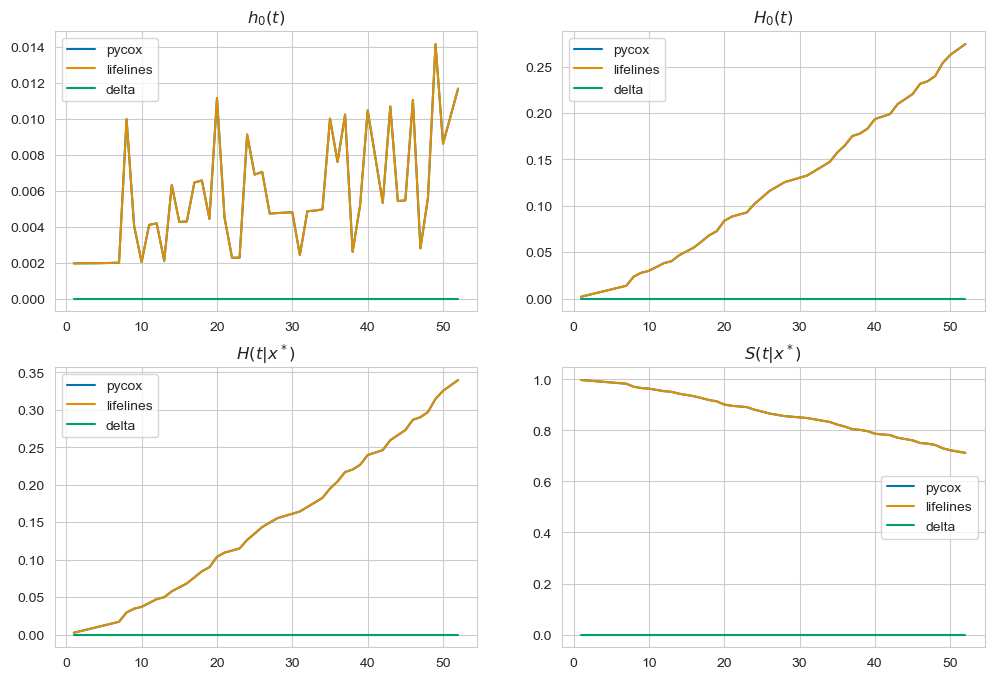

In [10]:
from pycox.models.cox import _CoxPHBase
import torchtuples as tt

class CustomPH(_CoxPHBase):
    def __init__(self, *args, **kwargs):
        pass

    def predict(self, X, *args, **kwargs):
        if isinstance(X, tt.TupleTree):
            X = X[0]
        return np.log(cph.predict_partial_hazard(X).to_numpy())

cc = CustomPH()

# This must run & store results in the cc object before predict_cumulative_hazards can run
h0_pred = cc.compute_baseline_hazards(X, (T, E))
h0_true = cph.baseline_hazard_["baseline hazard"]

H0_pred = cc.compute_baseline_cumulative_hazards(X, (T, E))
H0_true = cph.baseline_cumulative_hazard_["baseline cumulative hazard"]

H_pred = cc.predict_cumulative_hazards(X[5:6])[0]  # For a random row in X
H_true = cph.predict_cumulative_hazard(X[5:6])[0]

S_pred = cc.predict_surv(X[5:6])[0]  # For a random row in X
S_true = cph.predict_survival_function(X[5:6])[0]

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = np.ravel(ax)

pd.DataFrame(dict(pycox=h0_pred, lifelines=h0_true, delta=h0_pred - h0_true)).plot(
    ax=ax[0], title="$h_0(t)$"
)
pd.DataFrame(dict(pycox=H0_pred, lifelines=H0_true, delta=H0_pred - H0_true)).plot(
    ax=ax[1], title="$H_0(t)$"
)
pd.DataFrame(dict(pycox=H_pred, lifelines=H_true, delta=H_pred - H_true)).plot(
    ax=ax[2], title="$H(t|x^*)$"
)
pd.DataFrame(dict(pycox=S_pred, lifelines=S_true, delta=S_pred - S_true)).plot(
    ax=ax[3], title="$S(t|x^*)$"
)

(<Axes: title={'center': 'Smoothed calibration curve of \npredicted vs observed event probabilities by $T \\leq t_0$'}, xlabel='Predicted event probability by $t_0$: $1-\\hat S(t_0)$', ylabel='Observed event frequency by $T \\leq t_0$'>,
 np.float64(0.0010545645424831283),
 np.float64(0.0008669590370565805))

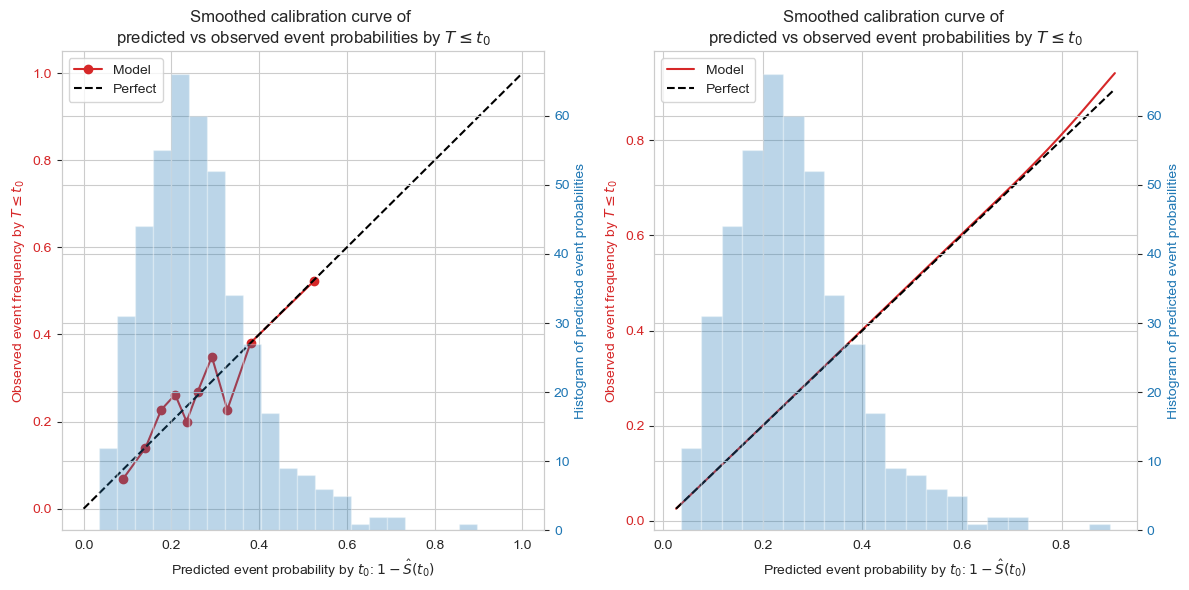

In [11]:
from survshares.plot import calibration_plot_binned, calibration_plot_smoothed
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
surv_pred_at_t0 = cph.predict_survival_function(X, times=[52]).T.squeeze()

calibration_plot_binned(surv_pred_at_t0, T, E, 52, ax=ax[0])
calibration_plot_smoothed(surv_pred_at_t0, T, E, 52, ax=ax[1])

### 3.1 Survival Estimands for `SymbolicRegressor`

We piggy-back off `pycox` and use their code for the above estimands. We wrap `SymbolicRegressor` in a child class of `_CoxPHBase` to do this. 

In [61]:
from gplearn_clean.gplearn.genetic import SymbolicRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from pycox.models.cox import _CoxPHBase
import torchtuples as tt


class SymRegPH(BaseEstimator, RegressorMixin, _CoxPHBase):
    """
    Wrapper for gplearn's SymbolicRegressor to use with pycox supporting functions
    """

    def __init__(self, **kwargs):
        self.model = SymbolicRegressor(**kwargs)

    def fit(self, X, y, sample_weight, *args, **kwargs):
        self.model.fit(X, y, sample_weight=sample_weight)
        return self

    def predict(self, X, *args, **kwargs):
        if isinstance(X, tt.TupleTree):
            X = X[0]
        return self.model.predict(X)

    def score(self, X, y, sample_weight, *args, **kwargs):
        y_pred = self.predict(X)
        return concordance_index(y, y_pred, sample_weight)

    def silent(self):
        return self.model.set_params(verbose=False)

In [53]:
from survshares.plot import calibration_plot_binned, calibration_plot_smoothed

class EvalSymRegPH:
    def __init__(self, model):
        self.model = model

    def score(self, X, T, E, sign=1):
        y_pred = sign * self.model.predict(X)
        h0_pred = self.model.compute_baseline_hazards(X, (T, E))
        surv_pred = self.model.predict_surv_df(X)
        print(f"C-index: {concordance_index(T, y_pred, E)}")
        print(f"Ranking loss: {metric_ranking_loss(T, y_pred, E)}")
        print(f"Partial likelihood: {metric_partial_likelihood(T, y_pred, E)}")
        print(f"IBS: {metric_integrated_brier(surv_pred, E, T)}")

    def plot_estimands(self, X, T, E, h0_scale_factor=1):
        # This must run & store results in the symreg_cidx object before predict_cumulative_hazards can run
        h0_pred = self.model.compute_baseline_hazards(X, (T, E))
        h0_pred_scaled = h0_pred * h0_scale_factor
        h0_true = cph.baseline_hazard_["baseline hazard"]
        h0_corr = h0_pred.corr(h0_true, method="pearson")

        H0_pred = self.model.compute_baseline_cumulative_hazards(
            baseline_hazards_=h0_pred_scaled
        )
        H0_true = cph.baseline_cumulative_hazard_["baseline cumulative hazard"]
        H0_corr = H0_pred.corr(H0_true, method="pearson")

        # Select a random row in X
        idx = np.random.randint(0, len(X) - 1)
        X_star = X[idx : idx + 1]

        H_pred = self.model.predict_cumulative_hazards(X_star, baseline_hazards_=h0_pred_scaled)[0]  # For a random row in X
        H_true = cph.predict_cumulative_hazard(X_star)[0]
        H_corr = H_pred.corr(H_true, method="pearson")

        S_pred = self.model.predict_surv(X_star, baseline_hazards_=h0_pred_scaled)[0]  # For a random row in X
        S_true = cph.predict_survival_function(X_star)[0]
        S_corr = pd.Series(S_pred).corr(S_true, method="pearson")

        fig, ax = plt.subplots(2, 2, figsize=(12, 8))
        ax = np.ravel(ax)

        h0_dict = dict(symreg=h0_pred, cox=h0_true, delta=h0_pred_scaled - h0_true)
        if h0_scale_factor != 1:
            h0_dict["symreg_scaled"] = h0_pred_scaled

        pd.DataFrame(h0_dict).plot(ax=ax[0], title=f"$h_0(t)$ - corr={h0_corr:.2f}")
        pd.DataFrame(dict(symreg=H0_pred, cox=H0_true, delta=H0_pred - H0_true)).plot(
            ax=ax[1], title=f"$H_0(t)$ - corr={H0_corr:.2f}"
        )
        pd.DataFrame(dict(symreg=H_pred, cox=H_true, delta=H_pred - H_true)).plot(
            ax=ax[2], title=f"$H(t|x^*)$ - corr={H_corr:.2f}"
        )
        pd.DataFrame(dict(symreg=S_pred, cox=S_true, delta=S_pred - S_true)).plot(
            ax=ax[3], title=f"$S(t|x^*)$ - corr={S_corr:.2f}"
        )

    def plot_calibration(self, X, T, E):
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        self.model.compute_baseline_hazards(X, (T, E))
        surv_pred = self.model.predict_surv_df(X)
        t0 = surv_pred.index.values[-1]
        surv_pred_at_t0 = surv_pred.iloc[-1, :].values.squeeze()

        calibration_plot_binned(surv_pred_at_t0, T, E, t0, ax=ax[0])
        calibration_plot_smoothed(surv_pred_at_t0, T, E, t0, ax=ax[1])

## 4. Proportional Hazards


### 4.1 Concordance Fitness
We train GPLearn with the (safe) concordance as the fitness function. This is a relative ranking metric & thus is scale- and shift-invariant, so we expect to get poor absolute risk predictions (bad calibration) but good rankings. 

I.e., the predicted hazards will be on the wrong scale & may be shifted. 

This has knock-on effects on numerical instability of downstream survival estimands like $H_0$. The calibration is therefore poor.

In [54]:
fitness_c_index = make_fitness(function=metric_c_index, greater_is_better=True)

symreg_c = SymRegPH(
    metric=fitness_c_index,
    population_size=500,
    generations=20,
    stopping_criteria=0.7,
    parsimony_coefficient="auto",
    feature_names=feature_names,
    verbose=True,
).fit(X, T, sample_weight=E)
symreg_c.model

/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


7
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    29.23         0.502995        7         0.626098              N/A      7.46s
   1    15.66         0.553515       19         0.640952              N/A      7.52s
   2     8.43         0.574167       19         0.642102              N/A      7.18s
   3     5.76         0.556227        9         0.642032              N/A      6.83s
   4     3.75         0.572209        7         0.637006              N/A      6.66s


KeyboardInterrupt: 

C-index: 0.6623455920341929
Ranking loss: 32.03260336825181
Partial likelihood: 32.11509882127205
IBS: 0.14059889691130933


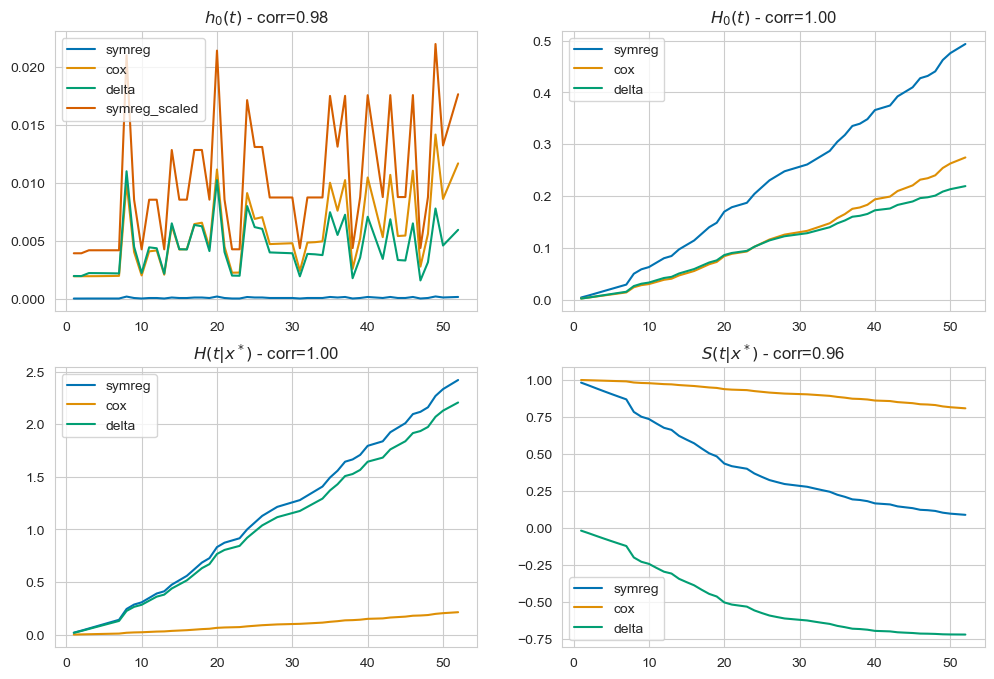

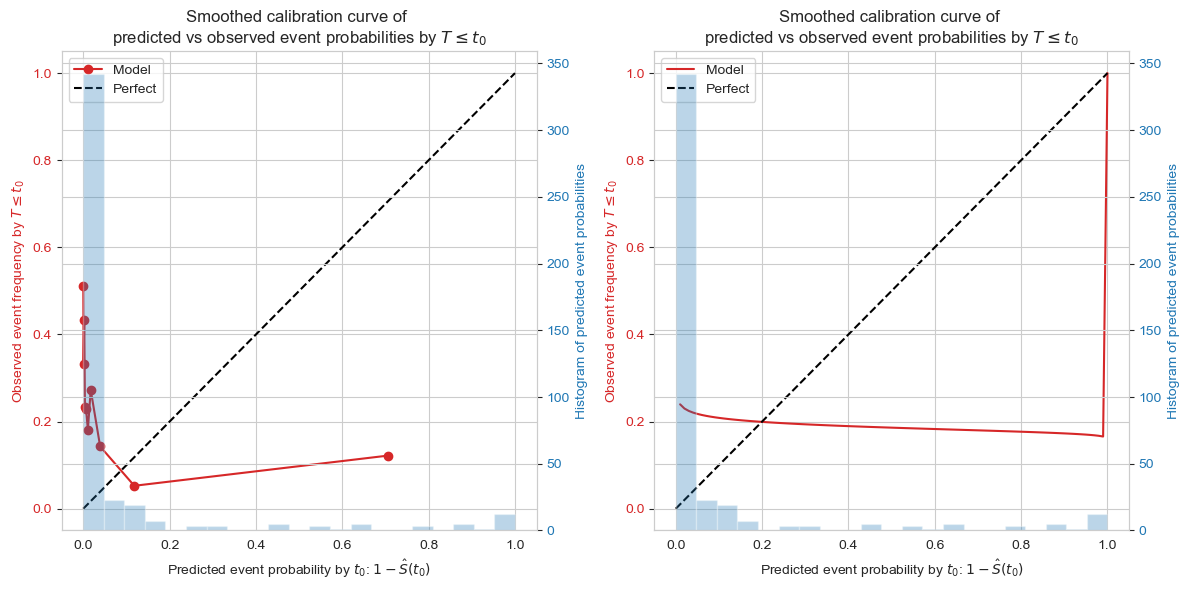

In [15]:
EvalSymRegPH(symreg_c).score(X, T, E)
EvalSymRegPH(symreg_c).plot_estimands(X, T, E, h0_scale_factor=100)
EvalSymRegPH(symreg_c).plot_calibration(X, T, E)

In [16]:
# Can't use `cross_validate` bc it won't pass the event indicators properly
# so we write a custom CV loop
from sklearn.model_selection import KFold
from joblib import Parallel, delayed
import time


class SurvivalCV:
    def __init__(self, model, score, sign=1):
        self.model = model
        self.score = score
        self.sign = sign

    @staticmethod
    def cv_fold(model, X, T, E, score, idx_train, idx_test, sign=1):
        fit_time_start = time.time()
        model.fit(X[idx_train], T[idx_train], sample_weight=E[idx_train])
        fit_time_stop = time.time()

        score_train, score_test = (
            score(T[idx_train], sign * model.predict(X[idx_train]), E[idx_train]),
            score(T[idx_test], sign * model.predict(X[idx_test]), E[idx_test]),
        )

        return fit_time_stop - fit_time_start, score_train, score_test

    def cross_validate(self, X, T, E, cv=5, n_jobs=-1):
        kf = KFold(n_splits=cv, shuffle=True, random_state=42)

        results = Parallel(n_jobs=n_jobs)(
            delayed(self.cv_fold)(
                self.model, X, T, E, self.score, train_idx, test_idx, self.sign
            )
            for train_idx, test_idx in kf.split(X)
        )

        fit_times, train_scores, test_scores = zip(*results)
        print(f"Mean fit time: {np.mean(fit_times):.4f}s")
        print(f"Train C: {np.mean(train_scores):.4f} ± {np.std(train_scores):.4f}")
        print(f"Test C: {np.mean(test_scores):.4f} ± {np.std(test_scores):.4f}")

        return results

In [17]:
cv_results_c = SurvivalCV(symreg_c.silent(), metric_c_index).cross_validate(
    X, T, E, cv=5, n_jobs=1
)

/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/stybl/mamba/envs/shares/

Mean fit time: 7.5649s
Train C: 0.6453 ± 0.0140
Test C: 0.6139 ± 0.0147


### 4.2 Shrink Penalty

We add a shrink penalty to the fitness function to encourage estimated $h$ values near $0$. This fixes the "scaling" issue. However, the calibration remains rubbish.

In [18]:
def fitness_c_shrink(y_true, y_pred, sample_weight):
    """
    Concordance index with shrink penalty for gplearn. Greater is better.
    """
    return metric_c_index(y_true, y_pred, sample_weight) - 0.05 * np.abs(y_pred).mean()


fitness_c_shrink = make_fitness(function=fitness_c_shrink, greater_is_better=True)

symreg_cs = SymRegPH(
    metric=fitness_c_shrink,
    population_size=500,
    generations=20,
    stopping_criteria=0.7,
    parsimony_coefficient=0.0,
    feature_names=feature_names,
    verbose=True,
).fit(X, T, sample_weight=E)
symreg_cs.model

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   0    25.48         -27044.2        7         0.580829              N/A      7.38s
   1     6.00         0.512857        5         0.607804              N/A      6.78s
   2     5.36         0.541321        7         0.614355              N/A      6.60s
   3     4.70         0.575229       11         0.626933              N/A      6.39s
   4     6.82          0.59457       15         0.631719              N/A      6.25s
   5    10.88         0.600889       21         0.635382              N/A      6.34s
   6    14.92         0.602015       21         0.636845              N/A      5.91s
   7    17.80         0.610278       25         0.637085              N/A      5.54s
   8    21.95          0.61566       31         0.639358              N/A      5.19s
   9    24.55         0.615975       43         0.644367              N/A      4.71s
  10    30.56          0.61312       53          0.64505              N/A      4.26s
  11    43.74         0.614207       51         0.647139         

SymbolicRegressor(feature_names=['fin', 'age', 'race', 'wexp', 'mar', 'paro',
                                 'prio'],
                  metric=<gplearn_clean.gplearn.fitness._Fitness object at 0x30aa9f490>,
                  parsimony_coefficient=0.0, population_size=500,
                  stopping_criteria=0.7, verbose=True)

C-index: 0.6591752383636278
Ranking loss: 5.875468197679292
Partial likelihood: 5.927354788672581
IBS: 0.10032461458972458


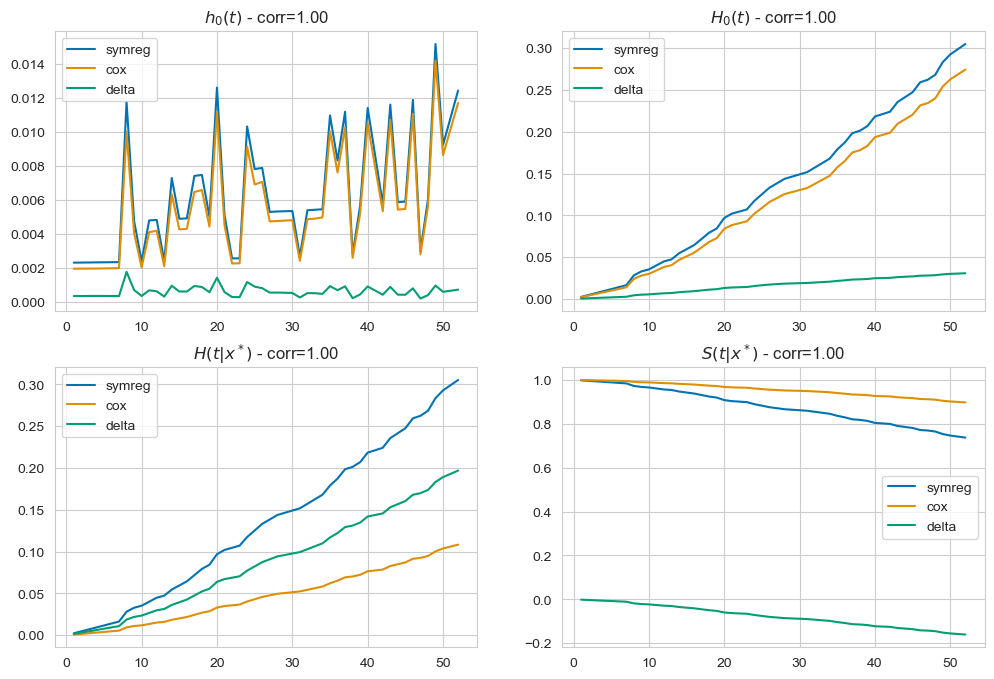

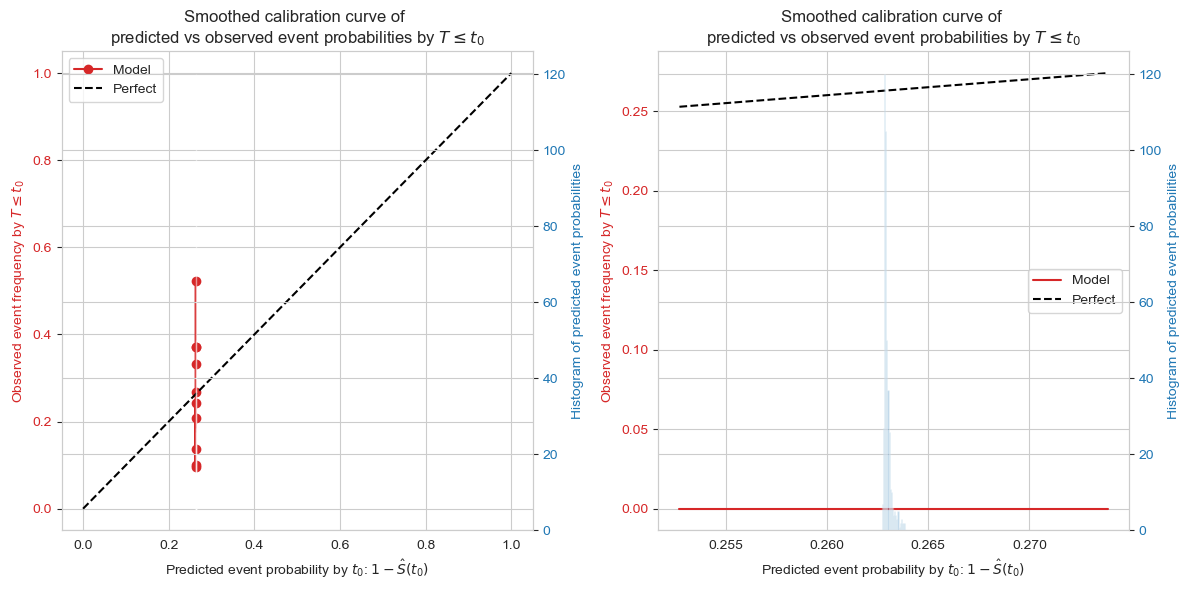

In [19]:
EvalSymRegPH(symreg_cs).score(X, T, E)
EvalSymRegPH(symreg_cs).plot_estimands(X, T, E)  # No scaling factor required
EvalSymRegPH(symreg_cs).plot_calibration(X, T, E)

In [20]:
cv_results_cs = SurvivalCV(symreg_cs.silent(), metric_c_index).cross_validate(
    X, T, E, cv=5, n_jobs=1
)

/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/stybl/mamba/envs/shares/

Mean fit time: 6.9377s
Train C: 0.6796 ± 0.0249
Test C: 0.5633 ± 0.0435


### 4.3 Log-Partial Likelihood Loss

This yields good discrimination and calibration. 

In [21]:
def fitness_pll_shrink(y_true, y_pred, sample_weight):
    """
    Partial log-likelihood with shrink penalty for gplearn. Smaller is better.
    """
    pll = metric_partial_likelihood(y_true, y_pred, sample_weight)
    return pll + 0.05 * np.abs(y_pred).mean()


fitness_pll_shrink = make_fitness(
    function=fitness_pll_shrink, greater_is_better=False
)

symreg_pl = SymRegPH(
    metric=fitness_pll_shrink,
    population_size=500,
    generations=20,
    stopping_criteria=0.7,
    parsimony_coefficient=0.00,
    feature_names=feature_names,
    verbose=True,
).fit(X, T, sample_weight=E)
symreg_pl.model

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   0    28.96              inf        5          5.87861              N/A      7.96s
   1     9.28              inf        7          5.86509              N/A      7.29s
   2     8.58          6.94305       11          5.86105              N/A      6.87s
   3     8.56          6.31953       13          5.85271              N/A      6.43s
   4     9.63          6.14545       11          5.84322              N/A      6.01s
   5    12.32          6.14296       17          5.84076              N/A      5.67s
   6    18.08          6.28505       13          5.83981              N/A      5.32s
   7    21.24          6.29505       19          5.83767              N/A      4.91s
   8    20.82          6.51129       43           5.8376              N/A      4.49s
   9    23.05          6.53654       43           5.8376              N/A      4.52s
  10    23.63             6.49       31          5.83563              N/A      3.71s
  11    30.05          6.35651       31          5.83563         

SymbolicRegressor(feature_names=['fin', 'age', 'race', 'wexp', 'mar', 'paro',
                                 'prio'],
                  metric=<gplearn_clean.gplearn.fitness._Fitness object at 0x30a987610>,
                  parsimony_coefficient=0.0, population_size=500,
                  stopping_criteria=0.7, verbose=True)

C-index: 0.6412686111502512
Ranking loss: 6.873715088121045
Partial likelihood: 6.924918272564959
IBS: 0.0976667720209053


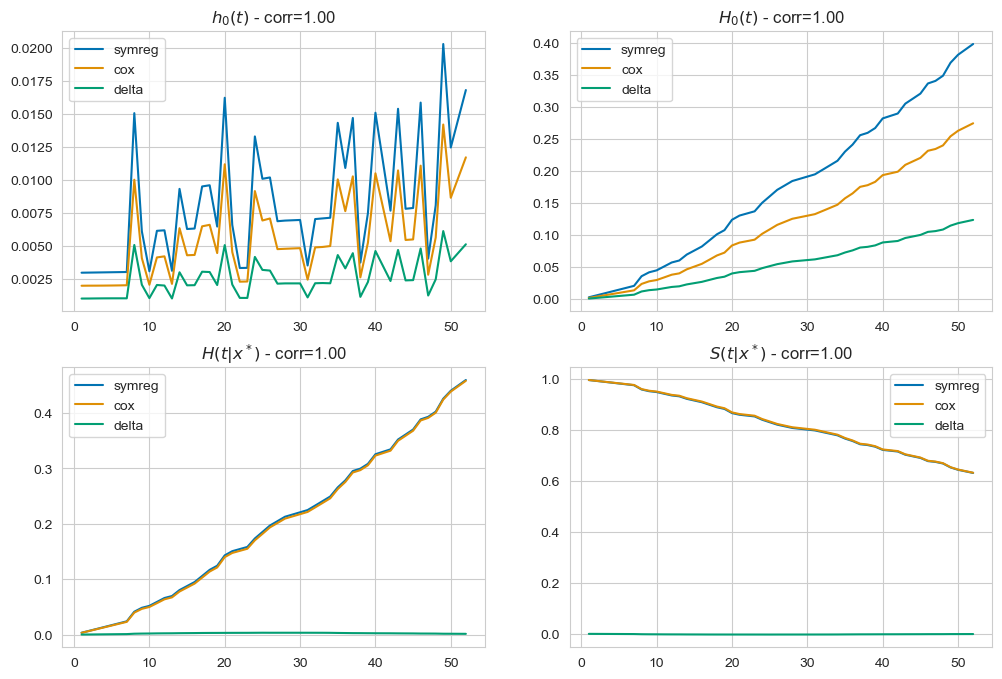

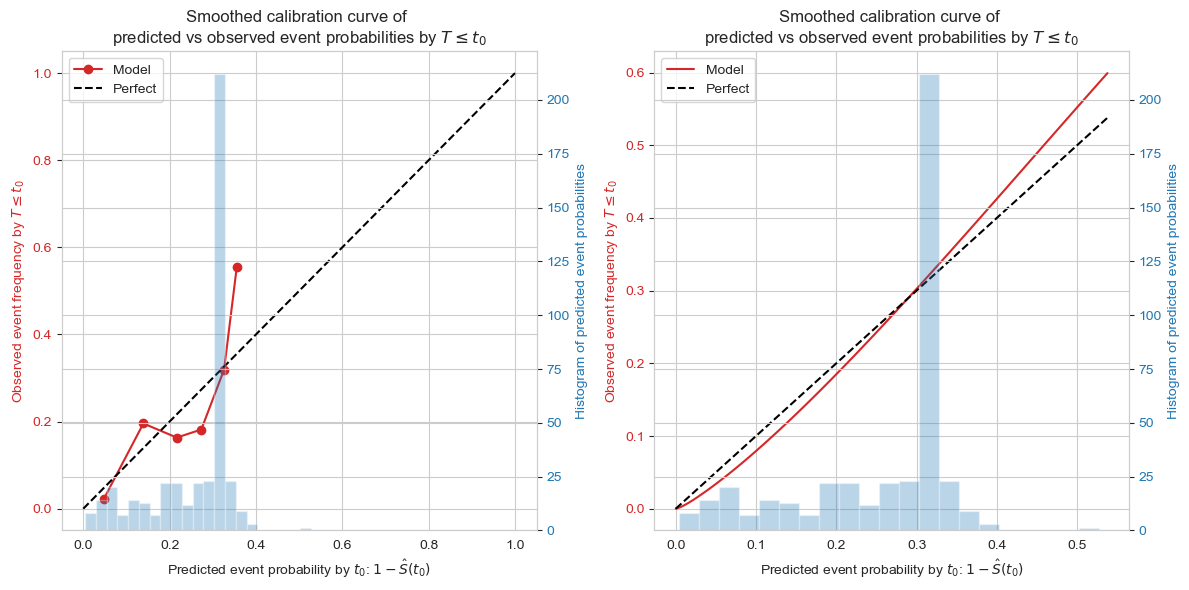

In [22]:
EvalSymRegPH(symreg_pl).score(X, T, E, sign=-1)
EvalSymRegPH(symreg_pl).plot_estimands(X, T, E)  # No scaling factor required
EvalSymRegPH(symreg_pl).plot_calibration(X, T, E)

In [23]:
cv_results_rl = SurvivalCV(symreg_pl.silent(), metric_c_index, sign=-1).cross_validate(
    X, T, E, cv=5, n_jobs=1
)

/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/stybl/mamba/envs/shares/

Mean fit time: 8.3945s
Train C: 0.6457 ± 0.0167
Test C: 0.5699 ± 0.0465


### 4.4 `torchsurv` Negative Partial Log-Likelihood Loss

In [24]:
def fitness_npll_shrink(y_true, y_pred, sample_weight):
    """
    Partial log-likelihood with shrink penalty for gplearn. Smaller is better.
    """
    pll = metric_torchsurv_pll(y_true, y_pred, sample_weight)
    return pll + 0.05 * np.abs(y_pred).mean()


fitness_npll_shrink = make_fitness(
    function=fitness_npll_shrink, greater_is_better=False
)

symreg_npll = SymRegPH(
    metric=fitness_npll_shrink,
    population_size=500,
    generations=20,
    stopping_criteria=0.7,
    parsimony_coefficient=0.001,
    feature_names=feature_names,
    verbose=True,
).fit(X, T, sample_weight=E)
symreg_npll.model

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/Users/stybl/mamba/envs/shares/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


   0    25.83              inf        7          13.7238              N/A     52.48s
   1     6.90              inf        9          13.6601              N/A     50.19s
   2     5.92              inf        7          13.5483              N/A     46.09s
   3     6.25          15.6468        9          13.5355              N/A     44.64s
   4     8.09          13.9615       17          13.5032              N/A     40.82s
   5     8.10           14.308       17           13.485              N/A     39.14s
   6    10.77          14.1342       19          13.4691              N/A     35.48s
   7    15.62          13.9055       27          13.4659              N/A     33.76s
   8    18.63          13.7612       29          13.4653              N/A     30.07s
   9    19.85          13.6835       31          13.4568              N/A     28.06s
  10    20.28          14.5113       39          13.4553              N/A     24.68s
  11    20.91          13.6552       27          13.4514         

SymbolicRegressor(feature_names=['fin', 'age', 'race', 'wexp', 'mar', 'paro',
                                 'prio'],
                  metric=<gplearn_clean.gplearn.fitness._Fitness object at 0x30973f210>,
                  population_size=500, stopping_criteria=0.7, verbose=True)

C-index: 0.6381687097834766
Ranking loss: 6.685049803521747
Partial likelihood: 6.732985050400594
IBS: 0.09515774031218732


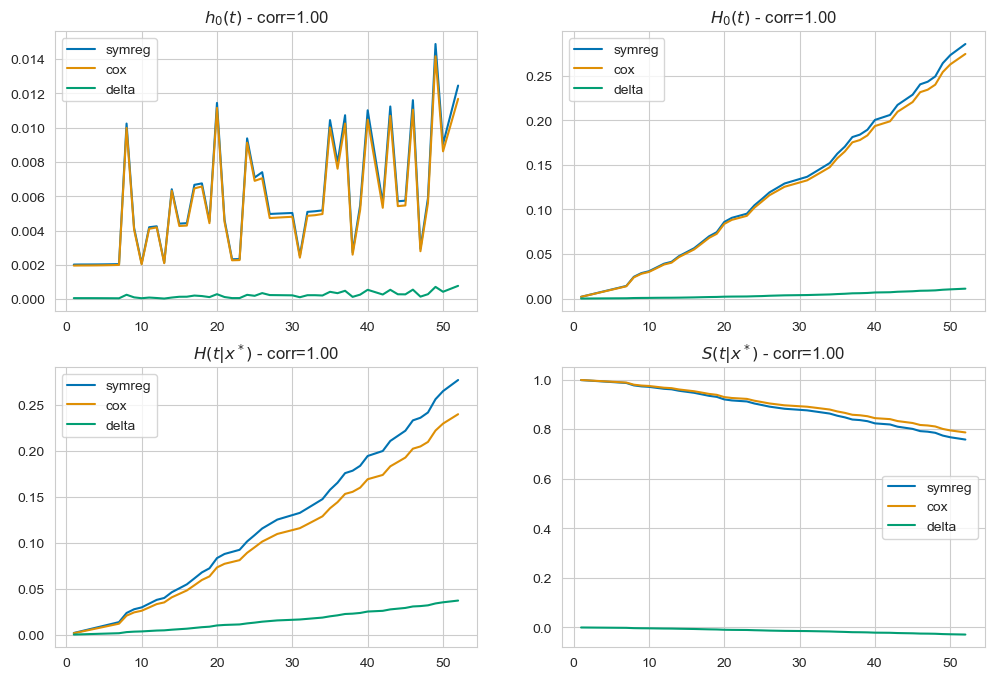

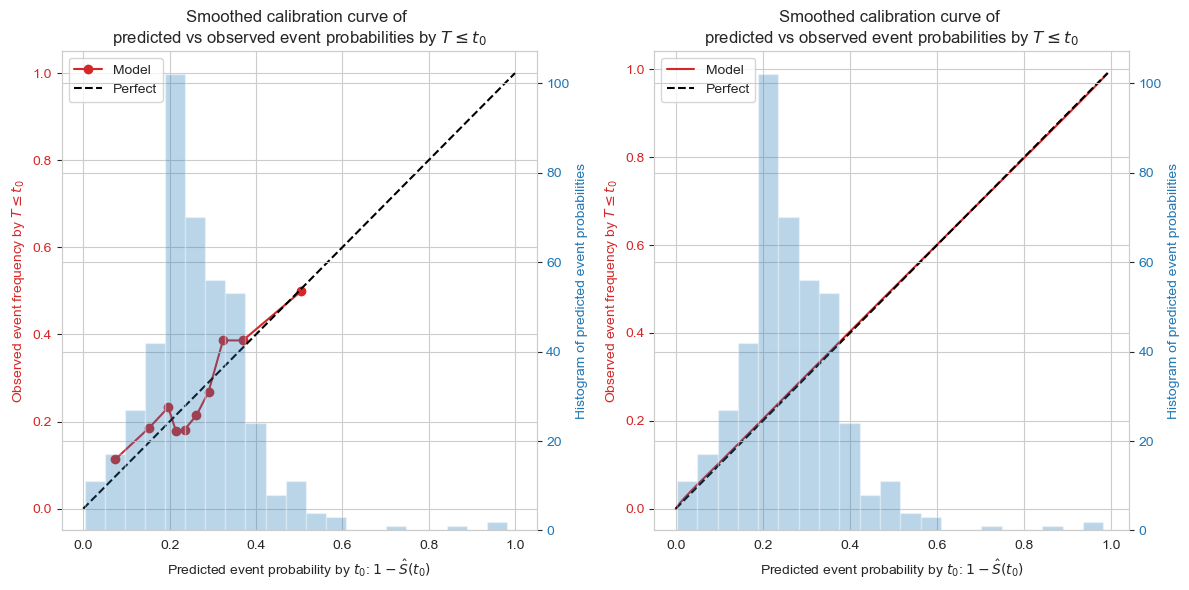

In [25]:
EvalSymRegPH(symreg_npll).score(X, T, E, sign=-1)
EvalSymRegPH(symreg_npll).plot_estimands(X, T, E)  # No scaling factor required
EvalSymRegPH(symreg_npll).plot_calibration(X, T, E)

{'mean_absolute_difference_binned': np.float64(0.035259629265578206),
 'mean_absolute_difference_smoothed': np.float64(0.0038037701213757794),
 'median_absolute_difference_binned': np.float64(0.03639976234553184),
 'median_absolute_difference_smoothed': np.float64(0.00395820754783488)}

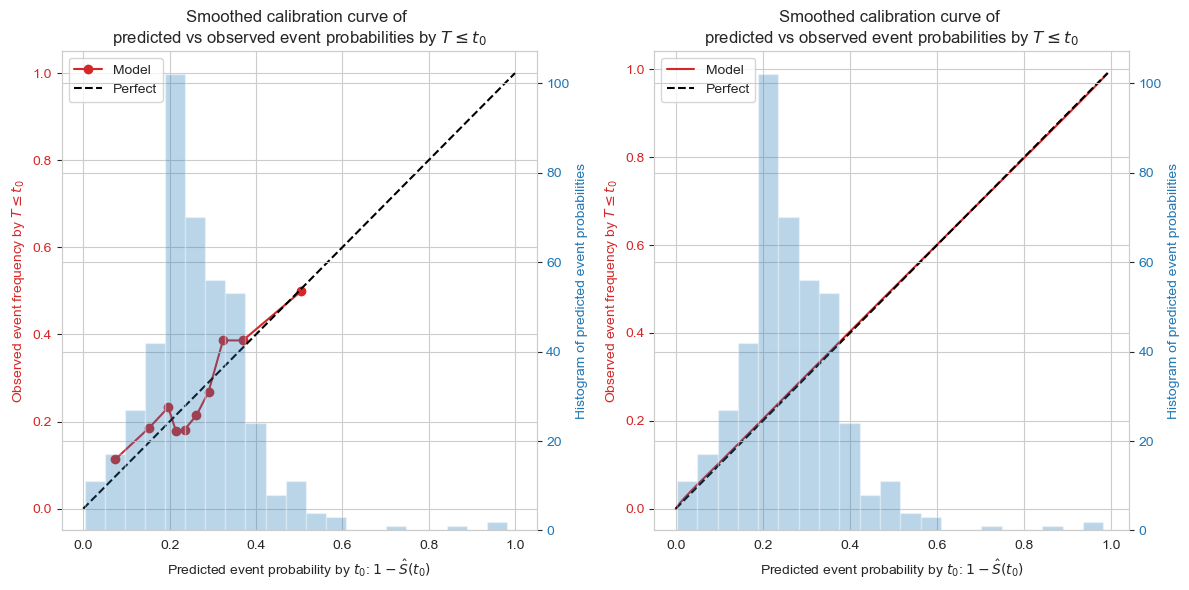

In [26]:
from survshares.hazard_model import HazardModel

model = HazardModel(symreg_npll.model).prepare_estimands(X, T, E)
model.score(X, T, E)
model.plot_calibration(X, T, E)

## 5. Non-Proportional Hazards

We switch from proportional hazards form $h(t|x) = h_0(t)\exp(g(x))$ to non-proportional hazards by allowing time to interact within $g$:

$$
h(t|x) = h_0(t)\exp(g(t|x))
$$

We retain the $h_0$ term to ensure feature-invariant components of the survival over time don't get cancelled out in the likelihood calculation.

In practice, we allow time to be a feature in the input $X$. This is analogous to how Cox-Time concatenates the event time to the input features. We expand each dataset record to have one row per unique event time (or per point in a discretised grid).

In [ ]:
import warnings 

def partial_log_likelihood_nph(predict_func, X, durations, events):
    def expg_sum(t, i):
        sub = input_sorted.iloc[i:]
        n = sub.shape[0]
        t = np.repeat(t, n).reshape(-1, 1).astype('float32')
        return np.exp(predict_func((sub, t))).sum()

    df = pd.DataFrame({"T": durations, "E": events})
    df = df.sort_values("T")
    input = pd.DataFrame(X)
    input_sorted = input.iloc[df.index.values]

    times =  (df
                .assign(_idx=np.arange(len(df)))
                .loc[lambda x: x["E"] == True]
                .drop_duplicates("T", keep='first')
                .assign(_expg_sum=lambda x: [expg_sum(t, i) for t, i in zip(x["T"], x['_idx'])])
                .drop(["E", '_idx'], axis=1))
    
    idx_name_old = df.index.name
    idx_name = '__' + idx_name_old if idx_name_old else '__index'
    df.index.name = idx_name

    pll = df.loc[lambda x: x["E"] == True]
    input_event = input.iloc[pll.index.values]
    durations_event = pll["T"].values.reshape(-1, 1)
    g_preds = predict_func((input_event, durations_event))
    pll = (pll
            .assign(_g_preds=g_preds)
            .reset_index()
            .merge(times, on="T")
            .set_index(idx_name)
            .assign(pll=lambda x: x['_g_preds'] - np.log(x['_expg_sum']))
            ['pll'])

    pll.index.name = idx_name_old
    return pll

def fitness_pll_nph(program, y_true, y_pred, sample_weight):
    """
    Partial log-likelihood for non-proportional hazards. Smaller is better.
    """
    X_true, T_true, E_true = y_true[:, :-2], y_true[:, -2], y_true[:, -1]
    predict_func = lambda XT: program.execute(np.hstack((XT[0], XT[1].reshape(-1, 1))))
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        pll = -partial_log_likelihood_nph(predict_func, X_true, T_true, E_true)
        
    result =  pll.mean() + 0.05 * np.abs(y_pred).mean()
    if result == -np.inf:
        return np.inf
    return result

In [ ]:
from gplearn_clean.gplearn.genetic import SymbolicRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from pycox.models.cox import _CoxPHBase
import torchtuples as tt
from gplearn_clean.gplearn.fitness import _Fitness

class SymRegNPH(BaseEstimator, RegressorMixin, _CoxPHBase):
    """
    Wrapper for gplearn's SymbolicRegressor to use with pycox supporting functions
    """

    def __init__(self, **kwargs):
        if "feature_names" in kwargs:
            kwargs["feature_names"] = feature_names + ['time']

        kwargs["metric"] = _Fitness(function=fitness_pll_nph,
                    greater_is_better=False)

        self.model = SymbolicRegressor(**kwargs)
        self.model._validate_data = lambda X, y, y_numeric: (X, y)
        self.model.n_features_in_ = len(feature_names) + 1  

    def fit(self, X, T, E, *args, **kwargs):
        X_in = np.hstack((X, T.reshape(-1, 1)))
        y_in = np.hstack((X, T.reshape(-1, 1), E.reshape(-1, 1)))
        self.model.fit(X_in, y_in)
        return self

    def predict(self, XT, *args, **kwargs):
        X, T = XT
        if isinstance(X, tt.TupleTree):
            X = X[0]
        if isinstance(T, tt.TupleTree):
            T = T[0]
        X_in = np.hstack((X, T.reshape(-1, 1)))
        return self.model.predict(X_in)
    
symreg_nph = SymRegNPH(
    population_size=500,
    generations=20,
    stopping_criteria=0.7,
    parsimony_coefficient=0.001,
    feature_names=feature_names,
    verbose=True,
).fit(X, T, E)
symreg_nph.model

SymbolicRegressor(feature_names=['fin', 'age', 'race', 'wexp', 'mar', 'paro',
                                 'prio', 'time'],
                  metric=<gplearn_clean.gplearn.fitness._Fitness object at 0x304409410>,
                  population_size=500, stopping_criteria=0.7, verbose=True)